# 目标检测数据集

我们收集并标记了一个小型数据集
下载数据集

In [4]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

读取香蕉检测数据集

In [5]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        targets.append(list(target))
        # 调用 unsqueeze(1) 方法在张量的维度 1 处插入了一个新的维度。这样做的目的是将原始的目标数据从形状为 (n,) 的一维张量转换为形状为 (n, 1) 的二维张量。
        # 这种操作通常用于将一维数据转换为二维数据，以便与其他张量进行广播或匹配操作。
    return images, torch.tensor(targets).unsqueeze(1) / 256

创建一个自定义`Dataset`实例

In [6]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

为训练集和测试集返回两个数据加载器实例

In [7]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

读取一个小批量，并打印其中的图像和标签的形状

In [8]:
# 图片大小为256
batch_size, edge_size = 32, 256
# train_iter负责管理整个训练数据,
# 而batch[0]和batch[1]只包含迭代器单次next()按顺序返回的一个batch的训练集数据。
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
# 32 1 5 batchsize 物体数 包围框坐标
# batch[0]是图像数据,batch[1]是对应的标签,它们是一个batch中的数据。
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


演示

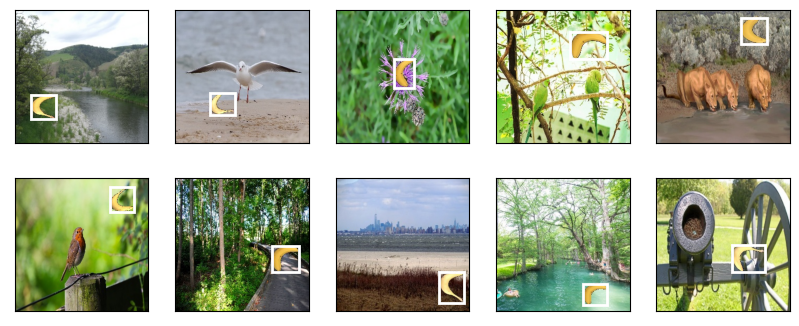

In [16]:
# 维度转换、通道数放后面
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
# axes = d2l.show_images(imgs, 2, 5, scale=2) 部分与之前的解释相同，
# 将处理过的图像数据显示为 2 行 5 列的图像，并设置了缩放比例为原始尺寸的两倍。
# axes 是图像显示的子图对象列表
axes = d2l.show_images(imgs, 2, 5, scale=2)
# label：shape[1,5]二维
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])